In [1]:
RASPBERRY_PI = True
if RASPBERRY_PI:
    !pip install .
else:        
    !pip install git+https://github.com/madhuhegde/super_resolution.git

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Processing /home/raspberry/work/diffusion/super_resolution
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for latent_diffusion: filename=latent_diffusion-0.1.1.dev0-py3-none-any.whl size=54432 sha256=37a577bc424cb413aeb640f3a75ddf98a6af197e497001a31c0d352c8f03981c
  Stored in directory: /tmp/pip-ephem-wheel-cache-qba0bepa/wheels/8a/9e/fc/9606ee38d70ee0844f42ced02fbec880d989c648ff7679b130
Successfully built latent_diffusion
  Attempting uninstall: latent_diffusion
    Found existing installation: latent_diffusion 0.1.1.dev0
    Uninstalling latent_diffusion-0.1.1.dev0:
      Successfully uninstalled latent_diffusion-0.1.1.dev0


In [2]:
from latent_diffusion import LDMSuperResolutionPipeline
import torch

# load model 
pipeline = LDMSuperResolutionPipeline() 


sample_size=64, in_channels=6,out_channels=3, center_input_sample=False,time_embedding_type=positional,freq_shift=0,flip_sin_to_cos=True
down_block_types=['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D'],up_block_types=['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D'], block_out_channels=[160, 320, 320, 640],layers_per_block=2,mid_block_scale_factor=1,downsample_padding=1,downsample_type=conv,upsample_type=conv,dropout=0.0,act_fn=silu
attention_head_dim=32,norm_num_groups=32,attn_norm_num_groups=None,norm_eps=1e-05,resnet_time_scale_shift=default,add_attention=True,class_embed_type=None,num_class_embeds=None,num_train_timesteps=None
in_channels=3,out_channels=3,up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'], block_out_channels=[128, 256, 512], layers_per_block=2, act_fn=silu,latent_channels=3
latent_channels=3, sample_size=256,num_vq_embeddings=8192, norm_num_groups=32, vq_embed_dim =3,scaling_factor=0.18215,norm_type=group


In [3]:
#set device
if RASPBERRY_PI:
   device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
   PATH_UNET = "/home/raspberry/work/diffusion/Unet_model_dict.pt"  
   PATH_VAE_DECODER = "/home/raspberry/work/diffusion/vae_decoder_model.pt" 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET)) #, map_location=torch.device('cpu'))) 
   pipeline.vaedecoder.load_state_dict(torch.load(PATH_VAE_DECODER)) 
else:
   PATH_VQVAE = "/Users/madhuhegde/work/diffusion/LDM/hf_vqvae_model.pt" #"VQ_model_dict.pt"
   PATH_UNET = "/Users/madhuhegde/work/diffusion/LDM/hf_unet_model.pt" 
   device = "cuda" if torch.cuda.is_available() else "cpu" 
   pipeline.vqvae.load_state_dict(torch.load(PATH_VQVAE)) 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET)) 


pipeline.unet.to(device)
pipeline.vaedecoder.to(device)

VAEDecoder(
  (quant_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (quantize): VectorQuantizer(
    (embedding): Embedding(8192, 3)
  )
  (post_quant_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Decoder(
    (conv_in): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (up_blocks): ModuleList(
      (0): UpDecoderBlock2D(
        (resnets): ModuleList(
          (0-2): 3 x ResnetBlock2D(
            (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
            (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (upsamplers): ModuleList(
          (0): Upsample2D(
            (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [4]:
import requests
from PIL import Image

image  = Image.open("/home/raspberry/Downloads/kairu.jpg").convert("RGB")
#low_res_img  = Image.open("/home/raspberry/work/diffusion/cifar10-64/train/class1/img4.png").convert("RGB")
image = image.crop((0, 40, 463, 503))
down_size_img = image.resize((96, 96))

# run pipeline in inference (sample random noise and denoise)
super_res_image = pipeline(down_size_img, num_inference_steps=20, eta=1).images[0]
# save image
#super_res_image.save("ldm_generated_image.png")

100%|███████████████████████████████████████████| 20/20 [02:49<00:00,  8.49s/it]
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may ha

In [5]:
import matplotlib.pyplot as plt

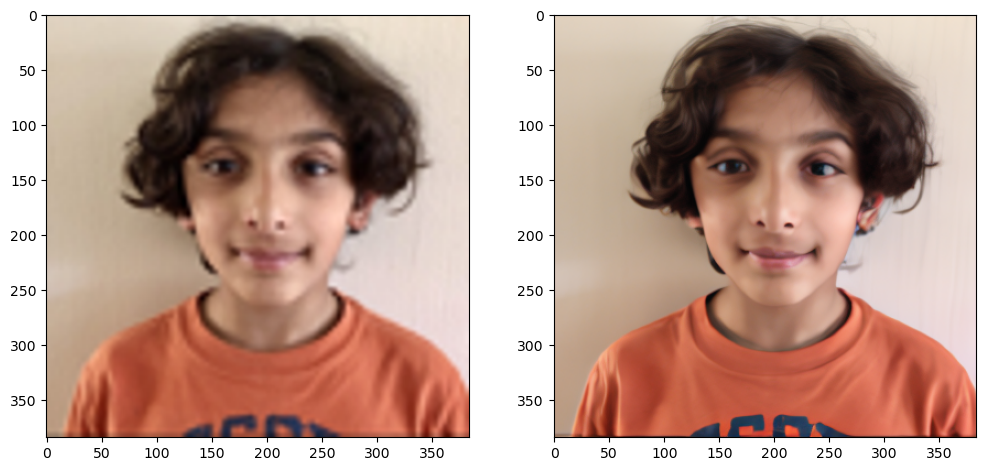

In [18]:
low_res_img = down_size_img.resize((96*4, 96*4))
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(low_res_img )
axarr[1].imshow(super_res_image )

In [12]:
image

(463, 463)